In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import plotly.express as px

## Explorando metódos de Interpolação

### reamostragem temporal (resampling): dias -> semana 
O Sistema de Informação de Agravos de Notificação (SINAN) utiliza um tipo de amostragem chamado Calendario Epidemiologico, onde é feita a divisão dos 365 dias do ano em 52 ou 53 semanas epidemiológicas. É uma forma de padronizar a variável tempo para fins de vigilância epidemiológica.

In [134]:
path = 'SRAG_time_series/SRAG_TS.csv'

df = pd.read_csv(path, sep=",", encoding="latin-1")
df["Date"] = pd.to_datetime(df["Date"])
df = df[(df['Date'].dt.year > 2018) & (df['Date'].dt.year < 2025)]
df

,Date,Number
1,2019-01-01,3
2,2019-01-02,12
3,2019-01-03,26
4,2019-01-04,35
5,2019-01-05,6
...,...,...
2188,2024-12-27,608
2189,2024-12-28,256
2190,2024-12-29,223
2191,2024-12-30,776


In [136]:
# Separando por semana epidemiologica
df['Year_Week'] = df['Date'].dt.strftime('%Y-%W')  # Combines year and week number
df

,Date,Number,Year_Week
1,2019-01-01,3,2019-00
2,2019-01-02,12,2019-00
3,2019-01-03,26,2019-00
4,2019-01-04,35,2019-00
5,2019-01-05,6,2019-00
...,...,...,...
2188,2024-12-27,608,2024-52
2189,2024-12-28,256,2024-52
2190,2024-12-29,223,2024-52
2191,2024-12-30,776,2024-53


In [138]:
#Agrupando os casos de cada semana
df_week =  df.groupby('Year_Week')['Number'].agg(sum).reset_index(name='Number_Cases')
df_week['Year_Week'] = pd.to_datetime(df_week['Year_Week'] + '-1', format='%Y-%W-%w')
df_week["week"] = df_week['Year_Week'].dt.isocalendar().week
df_week

C:\Users\aryck\AppData\Local\Temp\ipykernel_28280\81130712.py:2: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



,Year_Week,Number_Cases,week
0,2018-12-31,94,1
1,2019-01-07,256,2
2,2019-01-14,270,3
3,2019-01-21,273,4
4,2019-01-28,282,5
...,...,...,...
313,2024-12-02,4298,49
314,2024-12-09,4284,50
315,2024-12-16,4028,51
316,2024-12-23,3013,52


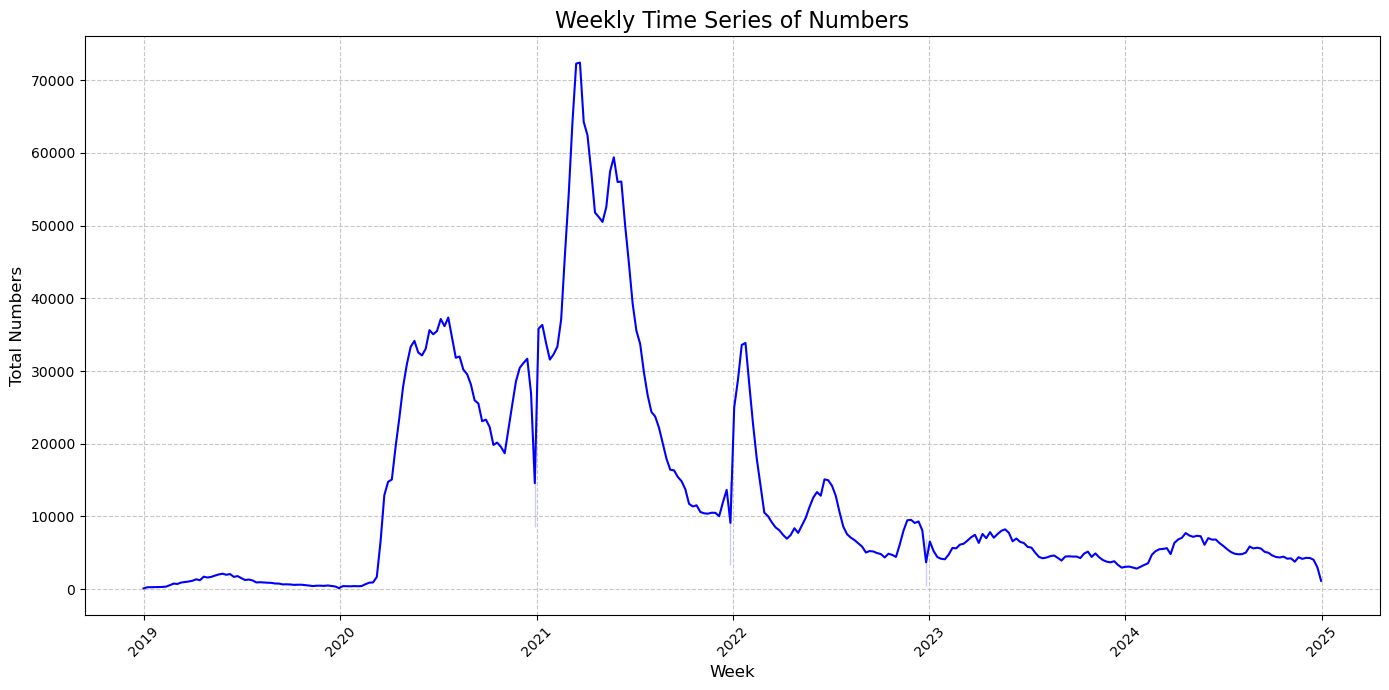

In [140]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_week, x='Year_Week', y='Number_Cases', color='b')

# Customize the plot
plt.title('Weekly Time Series of Numbers', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Total Numbers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

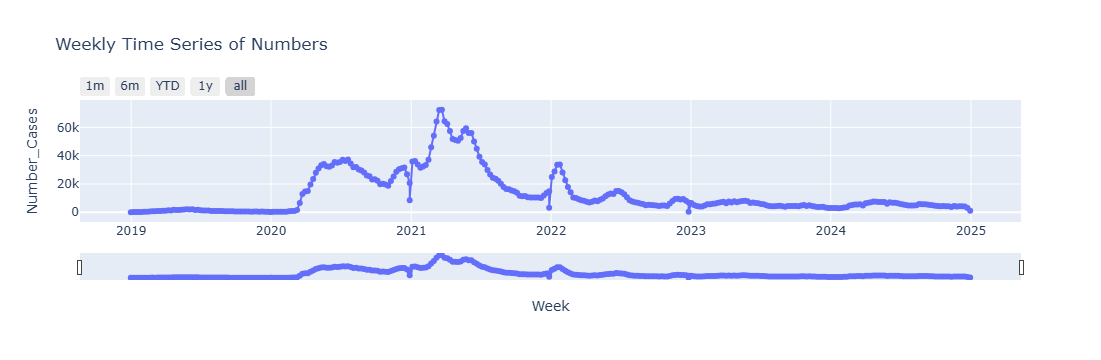

In [120]:
fig = px.line(df_week, x='Year_Week', y='Number_Cases',
              title='Weekly Time Series of Numbers',
              labels={'Year_Week': 'Week', 'Total_Numbers': 'Total Numbers'},
              markers=True)

# Add range slider for better navigation
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Add hover data
fig.update_traces(hovertemplate='Week: %{x|%Y-%U}<br>Total: %{y}')

fig.show()

### Aplicando Metodo Interpolate()
Nas semanas do ano com menos de 7 dias, para suavizar a serie temporal. (Não observamos diferenças significativas nos metodos: Linear e Spline )

In [188]:
# Identificando as últimas e primeiras semanas do ano
last_weeks = df_week[df_week["week"].isin([1, 52, 53])]
last_weeks.index

Index([  0,  51,  52,  53, 104, 105, 106, 107, 158, 159, 160, 211, 212, 213,
       264, 265, 316, 317],
      dtype='int64')

In [206]:
mask = df_week['week'].isin([1, 52, 53])

# Criar uma cópia da coluna Number_Cases
number_cases = df_week['Number_Cases'].copy()
# Aplicar interpolação apenas nos pontos selecionados
number_cases[mask] = np.nan
number_cases[mask] = number_cases.interpolate(method='linear')

In [208]:
# Atualizar a coluna no DataFrame
df_week['Number_Cases'] = number_cases

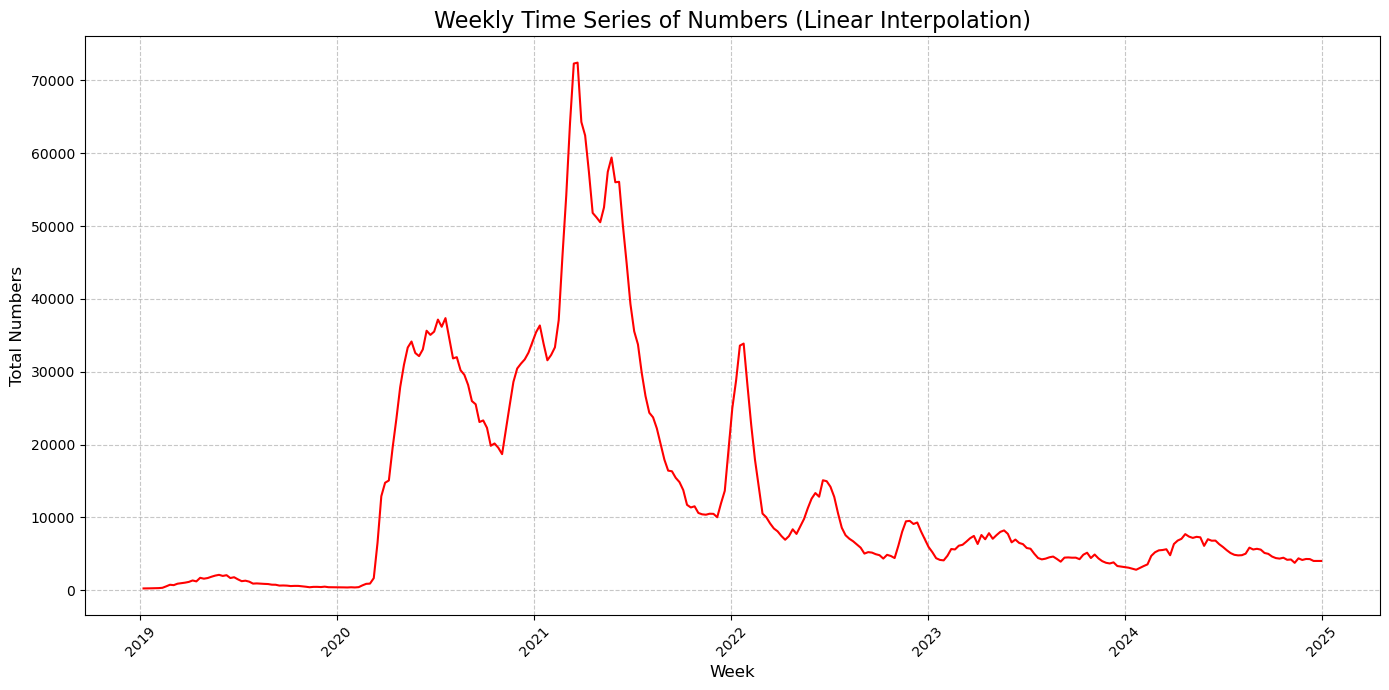

In [223]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_week, x='Year_Week', y='Number_Cases', color='r')

# Customize the plot
plt.title('Weekly Time Series of Numbers (Linear Interpolation)', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Total Numbers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

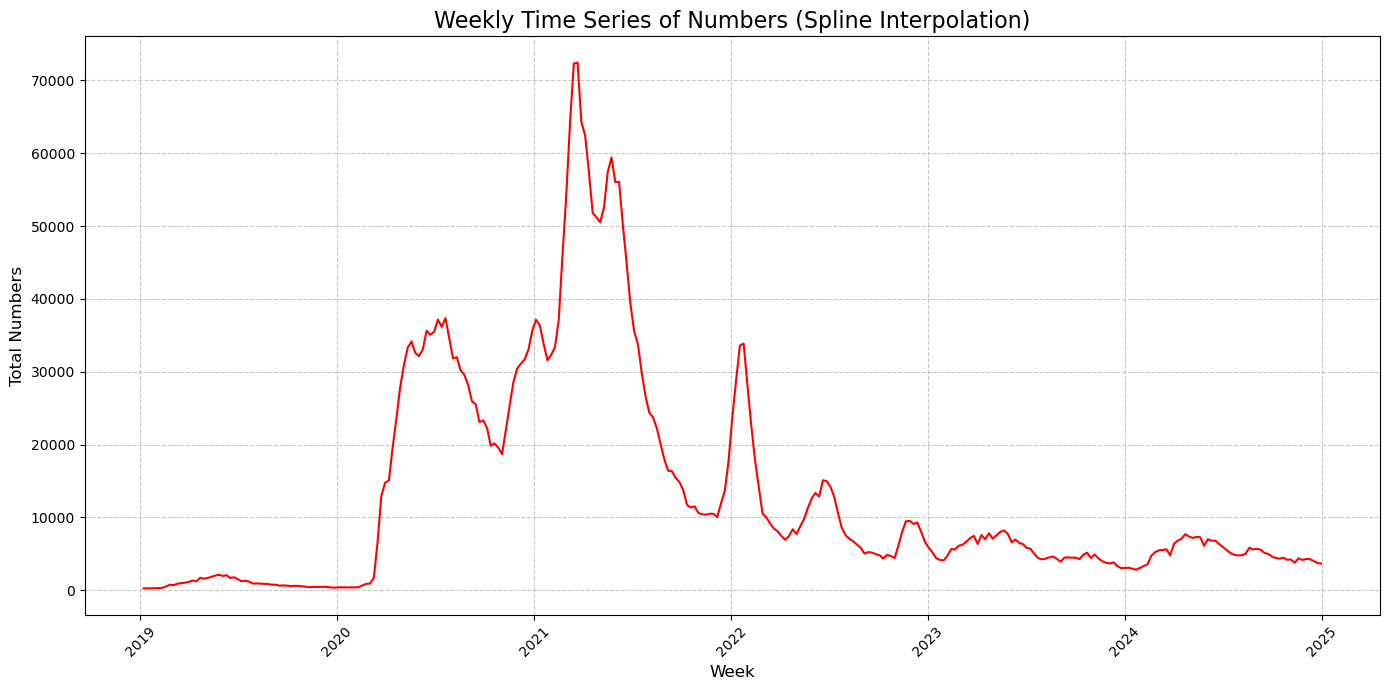

In [239]:
mask = df_week['week'].isin([1, 52, 53])

# Criar uma cópia da coluna Number_Cases
number_cases = df_week['Number_Cases'].copy()
# Aplicar interpolação apenas nos pontos selecionados
number_cases[mask] = np.nan
number_cases[mask] = number_cases.interpolate(method= 'spline', order=3)
# Atualizar a coluna no DataFrame
df_week['Number_Cases'] = number_cases

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_week, x='Year_Week', y='Number_Cases', color='r')

# Customize the plot
plt.title('Weekly Time Series of Numbers (Spline Interpolation)', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Total Numbers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [214]:
#salvando
df_week.to_csv('SRAG_time_series/SRAG_TS_weekly.csv', index=False)
print("CSV file saved successfully!")

CSV file saved successfully!
